<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Ressentis_distilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification de ressentis avec distilBERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Anglais) et attribue à chacun un ressenti positif ou négatif.  
Le modèle global est composé de deux parties :  
* [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) (une version allégée de BERT) va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec l'API [Keras](https://www.tensorflow.org/guide/keras?hl=fr) de [Tensorflow](https://www.tensorflow.org/?hl=fr).  

Nous testerons deux modèles de réseaux de neurones pour traiter les sorties de DistilBERT :  
* Un modèle très simple, composé de 2 neurones avec une fonction d'activation Softmax
* Un modèle plus complexe, qui sera en fait le même que celui utilisé lors de l'activité avec GloVe

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. On peut voir ces vecteurs comme l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

# **Installation et importation des librairies**


In [3]:
!pip install transformers sentencepiece --quiet

     |████████████████████████████████| 1.8MB 17.2MB/s 
     |████████████████████████████████| 1.2MB 56.2MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
     |████████████████████████████████| 890kB 57.2MB/s 


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import DistilBertConfig
from transformers import TFDistilBertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

# **Importation des données**

On utilise la librairie pandas pour lire les données depuis le fichier csv disponible sur le site de [standford](https://nlp.stanford.edu/sentiment/index.html) qui contient des commentaires sur des films, chacun d'eux avec une note positive (1) ou négative (0).

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/AlexandreBourrieau/ML/master/Carnets%20Jupyter/Donn%C3%A9es/train.csv', delimiter='\t', header=None)

Affiche quelques informations :

In [7]:
def LongueurMax(df):
  Lmax = 0
  for com in df[0]:
    Longueur = len(com)
    if Lmax < Longueur:
      Lmax = Longueur
  return Lmax

In [ ]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df[1].value_counts())
print("Longueur maximale d'un commentaire : ",LongueurMax(df))

                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1
5  campanella gets the tone just right funny in t...  1
6  a fan film that for the uninitiated plays bett...  0
7  b art and berling are both superb , while hupp...  1
8  a little less extreme than in the past , with ...  0
9                       the film is strictly routine  0
Total des données :  6920
Nombre d'avis positifs et négatifs :  1    3610
0    3310
Name: 1, dtype: int64
Longueur maximale d'un commentaire :  271


# **Préparation des données**


In [8]:
MAX = 3500

# Chargement des commentaires et des ressentis
commentaires = df[0].astype(str).tolist()    # Récupère tous les commentaires dans une liste python
ressentis = df[1].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)               # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires[0:MAX], labels[0:MAX], test_size=0.25)

In [ ]:
print ("Nombre de commentaires pour l'entrainement : ", len(x_entrainement))
print ("Nombre de commentaires pour les tests : ", len(x_test))

Nombre de commentaires pour l'entrainement :  2250
Nombre de commentaires pour les tests :  750


# Tokénisation  
La première étape est de tokéniser les commentaires : les mots sont décomposés en index numériques au format BERT.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/TokenizeBERT.png?raw=true" />

Après tokénisation, on obtient une liste de séquences et chaque séquence représente une liste d'index. On souhaite que BERT analyse toutes les séquences en une seule fois (ce qui est plus rapide). Il faut donc que toutes les séquences aient la même taille. On va donc ajouter du bourrage pour égaliser la longueur des séquences. Cela est indiqué avec le paramètre `padding='True'`.  
Lorsque un bourrage est ajouté, il faut que BERT ne prenne pas en compte les mots à cette position (car il n'y en a pas !). Cette restriction est réalisé grace à l'`attention_mask`

In [9]:
LONGUEUR_MAX_COMMENTAIRE = LongueurMax(df) + 2

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased',use_fast=False)

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Les commentaires sont maintenant tous tokénisés :


<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/SeparationData2.png"/>

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [ ]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(2250, 273), dtype=int32, numpy=
array([[  101,  2348,  2643, ...,     0,     0,     0],
       [  101,  1037, 10036, ...,     0,     0,     0],
       [  101,  2019,  3178, ...,     0,     0,     0],
       ...,
       [  101,  6187, 13469, ...,     0,     0,     0],
       [  101,  2071,  1045, ...,     0,     0,     0],
       [  101,  1996,  3185, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2250, 273), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Regardons comment le premier commentaire a été encodé :

In [ ]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0])

Commentaire original : although god is great addresses interesting matters of identity and heritage , it 's hard to shake the feeling that it was intended to be a different kind of film
input_ids:  tf.Tensor(
[  101  2348  2643  2003  2307 11596  5875  5609  1997  4767  1998  4348
  1010  2009  1005  1055  2524  2000  6073  1996  3110  2008  2009  2001
  3832  2000  2022  1037  2367  2785  1997  2143   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 

Regardons les 3 premiers résultats de la tokénisation : On peut identifier les mot-clés **[CLS]** (valeur : 101) et **[SEP]** (valeur : 102)

In [ ]:
for i in range (0,3):
  print(output_tokenizer_entrainement['input_ids'][i])

# **Définition et utilisation du modèle distilBERT avec Keras**

Les données d'entrées étant maintenant correctement préparées, commençons par définir le modèle distilBERT pour ensuite l'appliquer aux données afin de réaliser l'opération de prolongation lexicale.  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/distilBERT_process.png" style="width: 600px;"/>.

In [10]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)             # 2 labels en sortie

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_distilBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_distilBERT,trainable=False)
model_distilBERT.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7ff6b316d2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7ff6b316d2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf

Pour chaque commentaire en entrée, la sortie du modèle distilBERT est un vecteur de dimension MAX_SEQUENCE_LENGTH :
* Il y a au maximum MAX_SEQUENCE_LENGTH mots dans chaque commentaire
* Il y a un vecteur en sortie du modèle par mot dans chaque commentaire
* Le vecteur qui code chaque mot est de dimension 768

Vérifions cela en regardant le format de la sortie du modèle :

In [ ]:
sortie_distilBERT

TFBaseModelOutput([('last_hidden_state',
                    <KerasTensor: shape=(None, 273, 768) dtype=float32 (created by layer 'tf_distil_bert_model')>)])

La fonction `predict()` permet d'exécuter le modèle sur les séquences d'entrées

In [ ]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:2],
     output_tokenizer_entrainement['attention_mask'][0:2]]
     ,verbose=1)

1/1 [==============================] - 2s 2s/step


Regardons à quoi ressemble la sortie de distilBERT :


<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/distilBERT_process.png" style="width: 600px;"/>.

In [ ]:
sortie_vecteurs_distilBERT

TFBaseModelOutput([('last_hidden_state',
                    array([[[ 0.12697634,  0.07267125, -0.20222826, ..., -0.03190329,
                              0.5445315 ,  0.4806475 ],
                            [-0.26458287,  0.567291  , -0.16895247, ..., -0.09016019,
                              0.3716725 ,  0.69785666],
                            [ 0.19972987,  0.40689173, -0.1078022 , ...,  0.2005468 ,
                              0.5142505 ,  0.34432217],
                            ...,
                            [ 0.02515908, -0.08468235, -0.10614525, ...,  0.23914665,
                              0.20634145,  0.17430647],
                            [ 0.03855621, -0.09520001, -0.08530612, ...,  0.22041687,
                              0.1828146 ,  0.1669421 ],
                            [ 0.04170456, -0.05432995, -0.10127669, ...,  0.22181287,
                              0.17507976,  0.17163457]],
                    
                           [[ 0.04641276, -0.1116624

Regardons par exemple le vecteur de dimension 768, résultant de l'encodage du [CLS] du premier commentaire : 

In [ ]:
sortie_vecteurs_distilBERT[0][0][0]

Exécutons maintenant distilBERT sur les 10 premiers commentaires afin de regarder le format des sorties obtenues :

In [ ]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:10],
     output_tokenizer_entrainement['attention_mask'][0:10]]
     ,verbose=1)
print("Commentaire :", commentaires[1])
print("input_ids", output_tokenizer_entrainement['input_ids'][1])
print("Sortie BERT", sortie_vecteurs_distilBERT[0][:,0,:])

1/1 [==============================] - 0s 259ms/step
Commentaire : apparently reassembled from the cutting room floor of any given daytime soap
input_ids tf.Tensor(
[  101  1037 10036  8040  3286  2404  2362  2011  2070 26881 19815  2015
  2012  4329  4835  1998  5674  4024  2000  2191  1996 26476  2015  2041
  2045  7806  1023  1998  6109  2781  1997  4895  2890  3597 26061  3468
  2166   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0  

# **Ajout du réseau de neurones simple en sortie du modèle distilBERT**

**Extraction des vecteurs [CLS]**

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  
  
  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Slice_SortieBERT.png?raw=true"/>  

In [ ]:
sortie_distilBERT[0]

<KerasTensor: shape=(None, 273, 768) dtype=float32 (created by layer 'tf_distil_bert_model')>

In [ ]:
sortie_distilBERT[0][:,0,:]

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem_31')>

**Construction du modèle global**

Les vecteurs de dimension 768 correspondants aux sorties [CLS] de chaque commentaire sont envoyés dans un réseau de neurones à 2 neurones avec une fonction d'activation Softmax :
<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT1.png"/>

In [11]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 1 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])[0]


l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_distilBERT)        # On ne récupère que les vecteurs [CLS]
output = Dense(2, activation='softmax')(l1)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.layers[2].trainable = False         # Désactive d'entrainement de distilBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           tf_distil_bert_model_1[0][7

On lance maintenant l'entrainement du modèle :

In [ ]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))


Epoch 1/5
750/750 [==============================] - 71s 88ms/step - loss: 0.6055 - accuracy: 0.6681 - val_loss: 0.4129 - val_accuracy: 0.8333
Epoch 2/5
750/750 [==============================] - 65s 86ms/step - loss: 0.4473 - accuracy: 0.8005 - val_loss: 0.3823 - val_accuracy: 0.8347
Epoch 3/5
750/750 [==============================] - 65s 86ms/step - loss: 0.4048 - accuracy: 0.8205 - val_loss: 0.3751 - val_accuracy: 0.8400
Epoch 4/5
750/750 [==============================] - 65s 86ms/step - loss: 0.3918 - accuracy: 0.8269 - val_loss: 0.3654 - val_accuracy: 0.8333
Epoch 5/5
750/750 [==============================] - 65s 86ms/step - loss: 0.4070 - accuracy: 0.8210 - val_loss: 0.3765 - val_accuracy: 0.8293


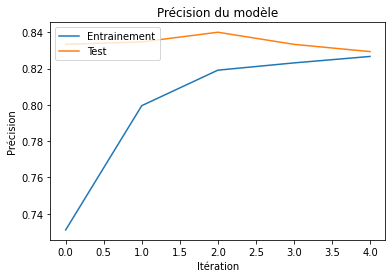

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

Afin d'obtenir une meilleur précision, on va également entrainer distilBERT : 

In [12]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           tf_distil_bert_model_1[0][7

In [13]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
1625/1625 [==============================] - 194s 117ms/step - loss: 0.6017 - accuracy: 0.6587 - val_loss: 0.3575 - val_accuracy: 0.8418
Epoch 2/5
1625/1625 [==============================] - 190s 117ms/step - loss: 0.3157 - accuracy: 0.8698 - val_loss: 0.3444 - val_accuracy: 0.8492
Epoch 3/5
1625/1625 [==============================] - 189s 117ms/step - loss: 0.2534 - accuracy: 0.8982 - val_loss: 0.3214 - val_accuracy: 0.8646
Epoch 4/5
1625/1625 [==============================] - 190s 117ms/step - loss: 0.2187 - accuracy: 0.9137 - val_loss: 0.3292 - val_accuracy: 0.8646
Epoch 5/5
1625/1625 [==============================] - 189s 116ms/step - loss: 0.1818 - accuracy: 0.9269 - val_loss: 0.3314 - val_accuracy: 0.8720


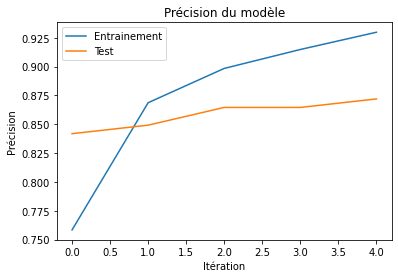

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# **Un modèle plus complexe**

Cette fois, les vecteurs de dimension 768 correspondants aux sorties [CLS] de chaque commentaire sont envoyés au même modèle que celui utilisé lors de l'activité avec GloVe :
<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT3.png"/>

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT4.png"/>

In [ ]:
dropout = 0.4

# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 1 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])[0]

l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_distilBERT)
l2 = Conv1D(128, 5, activation='relu', padding='same', strides=2)(tf.expand_dims(l1,axis=1))
l3 = GlobalMaxPooling1D()(l2)
l4 = Dropout(dropout)(l3)
l5 = Dense(128, activation='relu')(l4)
l6 = Dropout(dropout)(l5)
l7 = Dense(2, activation='softmax')(l6)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = l7)
model.layers[2].trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

**Fine-tuning**

Afin de tenter d'obtenir une meilleur précision, on va également entrainer distilBERT : 

In [ ]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()